# Ensemble_Test

Jacob Baxley

In [485]:
# Clear all variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [486]:
#Import relevant packages.

import numpy as np
from scipy import stats
# Import curve fitting package from scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller #Test stationary data
#from fbm import fbm, fgn
# from matplotlib import rc
#import colorama

plt.style.use('ggplot')  # Set plot style

In [487]:
%%capture

%run Diffusion-Entropy-Analysis/DEA.ipynb


### We need to create new functions for ensembles

In [21]:
def old_no_stripe_entropy(trajectory, window_lengths):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. FOR NO STRIPES JUST PASS THE DATA SERIES.

    Returns
    ----------
    S : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L.

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    #window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)
    S = []
    for L in tqdm(window_lengths):
        window_starts = np.arange(0, len(trajectory)-L, 1)
        window_ends = np.arange(L, len(trajectory), 1)
        traj = trajectory[window_starts] - trajectory[window_ends]
        counts, bin_edge = np.histogram(traj, bins='doane')  # doane least bad for nongaussian
        counts = np.array(counts[counts != 0])
        binsize = bin_edge[1] - bin_edge[0]
        P = counts / sum(counts)
        S.append(-sum(P*np.log(P)) + np.log(binsize))
    return S, window_lengths

In [32]:
def new_no_stripe_entropy(trajectory, window_lengths):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.
    
    When imputing a matrix a growing window will be used.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. FOR NO STRIPES JUST PASS THE DATA SERIES.

    Returns
    ----------
    S : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L.

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    
    #First convert both list to numpy arrays.
    trajectory = np.array(trajectory)
    window_lengths = np.array(window_lengths)
            
    #Now see if you have a list or a matrix.
    if len(np.shape(trajectory)) < 2: #The shape of a matrix has 2 numbers.
        trajectory = np.array([trajectory]) #Make the list a psudo matrix with "[list]"
        growing_window = False #Don't use the growing window.
    else:
        growing_window = True #Use the growing window.
        
    S = [] #This will hold the entropy.
    for L in tqdm(window_lengths): #Step through each window length.
        if growing_window:
            window_starts = 0
            window_ends = L
        else:
            #Moving window
            window_starts = np.arange(0, np.shape(trajectory[0])-L, 1)
            window_ends = np.arange(L, np.shape(trajectory[0]), 1)
        traj = trajectory[:,window_starts].T - trajectory[:,window_ends].T
        counts, bin_edge = np.histogram(traj, bins='doane')  # doane least bad for nongaussian
        counts = np.array(counts[counts != 0])
        binsize = bin_edge[1] - bin_edge[0]
        P = counts / sum(counts)
        S.append(-sum(P*np.log(P)) + np.log(binsize)) #Shannon Entropy
    return S, window_lengths

### Now lets look at a random walk single trajectory vs ensemble

Text(0, 0.5, 'x')

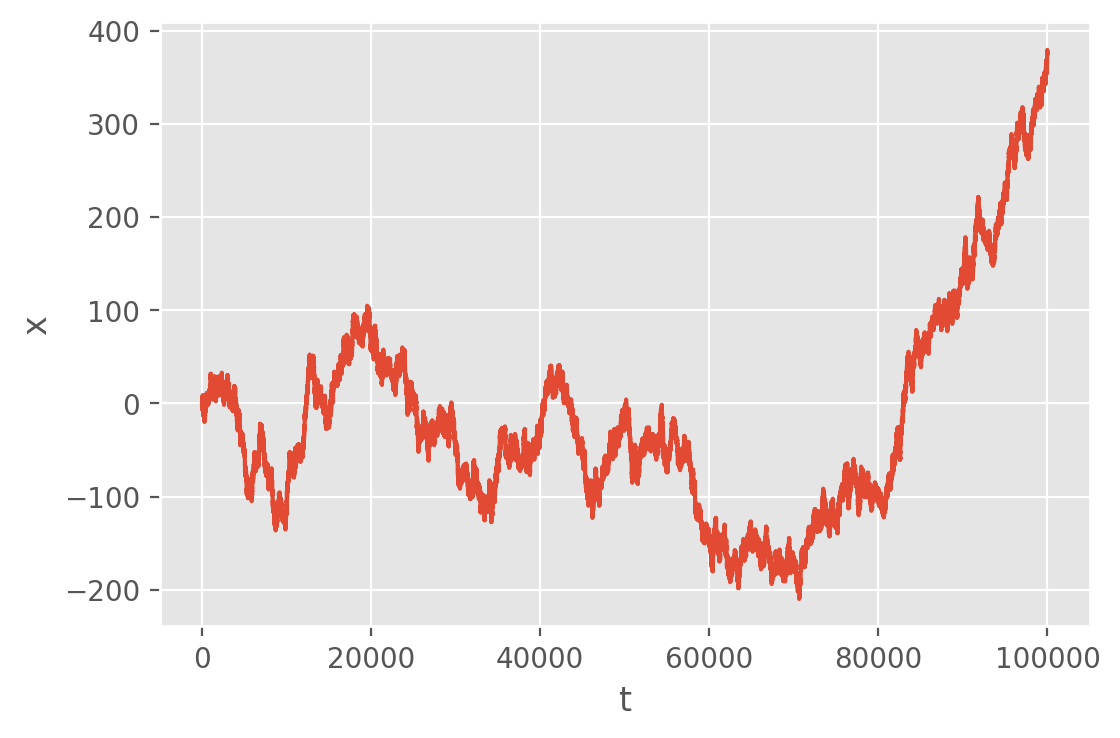

In [488]:
# Now let's look at a random walk

def random_walk(start, L, lamb):
    fluct = np.concatenate(([start],lamb*np.random.normal(loc=0.0, scale=np.sqrt(1.0), size=(L-1))))
    return np.cumsum(fluct)

start = 0.0001
L = 1*10**5
step_constant = 1
lamb = 1/step_constant

x = random_walk(start, L, lamb)

plt.plot(x)
plt.xlabel('t')
plt.ylabel('x')

In [42]:
number_of_points = 100 #may not repeat
data = x

window_lengths = np.unique(np.exp(np.arange(0,np.log(len(data)),np.log(len(data))/number_of_points)).astype(int))

s, L = no_stripe_entropy(data, window_lengths)

100%|██████████| 93/93 [00:59<00:00,  1.56it/s]


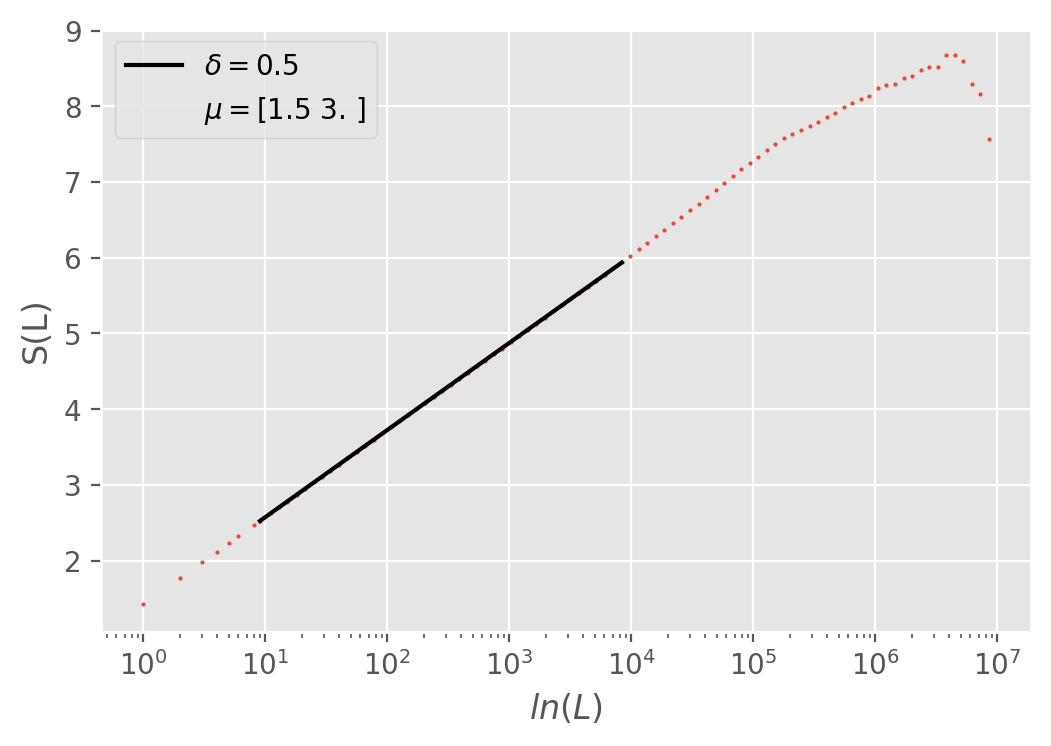

In [43]:
#for fitting and to get the scaling
start = 1*10**1
stop = 1*10**4
fit = get_scaling(s, L, start, stop)
mu = get_mu(fit[1][0])

plt.scatter(L, s, 1)
plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
        label='$\delta = $'+str(np.round(fit[1][0], 2)))
plt.plot([], [], linestyle='', label='$\mu = $'+str(np.round(mu, 2)))
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('S(L)')
plt.legend(loc=0)

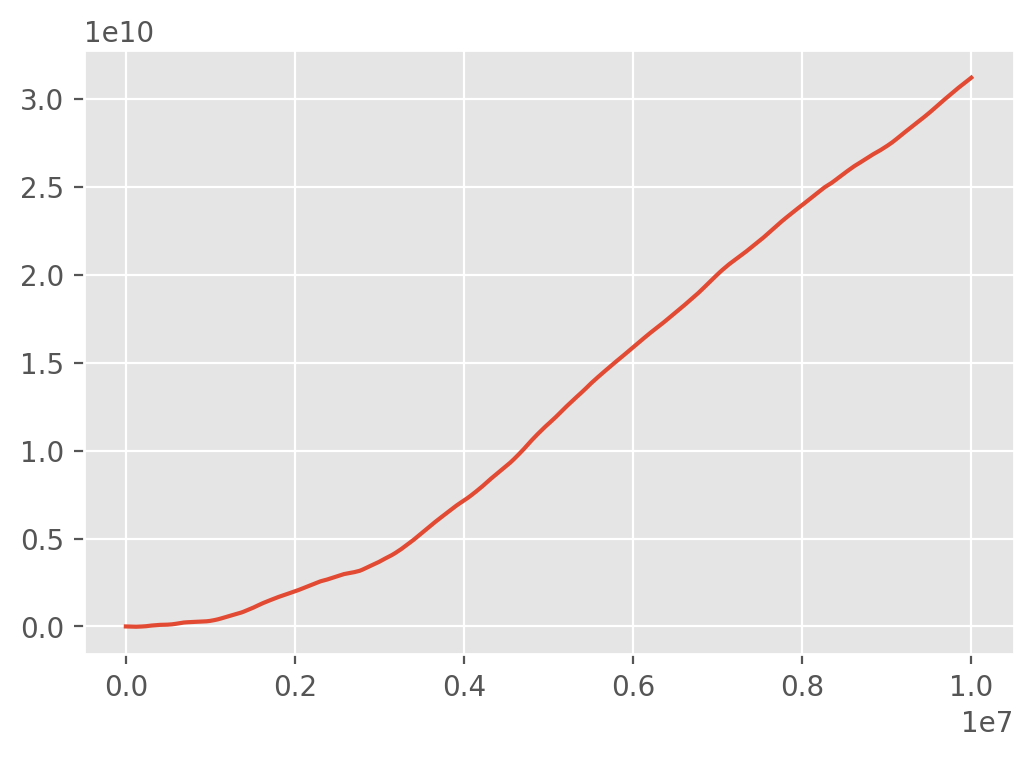

In [44]:
y = np.cumsum(x)

_ = plt.plot(y)

In [45]:
number_of_points = 100 #may not repeat
data = y

window_lengths = np.unique(np.exp(np.arange(0,np.log(len(data)),np.log(len(data))/number_of_points)).astype(int))

s, L = no_stripe_entropy(data, window_lengths)

100%|██████████| 93/93 [01:07<00:00,  1.38it/s]


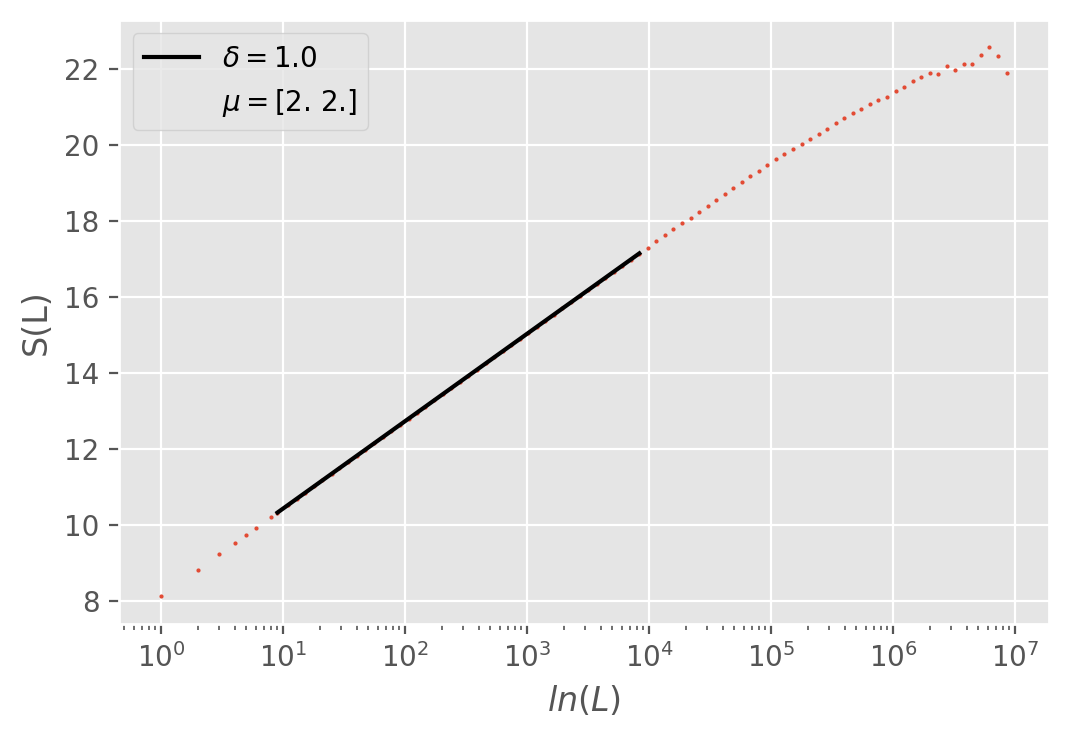

In [363]:
#for fitting and to get the scaling
start = 1*10**1
stop = 1*10**4
fit = get_scaling(s, L, start, stop)
mu = get_mu(fit[1][0])

plt.scatter(L, s, 1)
plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
        label='$\delta = $'+str(np.round(fit[1][0], 2)))
plt.plot([], [], linestyle='', label='$\mu = $'+str(np.round(mu, 2)))
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('S(L)')
plt.legend(loc=0)

Note that the $\delta = 1$ instead of $\delta = 1.5$

We need to consider that y is nonstationary. 

In [43]:
# First we will consider drawing may trajectories with the random walk function.

step_constants = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

start = 0.0001
L = 10**7
lamb = 1/step_constants

x_trajs = np.zeros([len(lamb),L])

for q in range(len(lamb)):
    x_trajs[q] = np.cumsum(random_walk(start, L, lamb[q]))
    
    
#plt.plot(x_trajs)


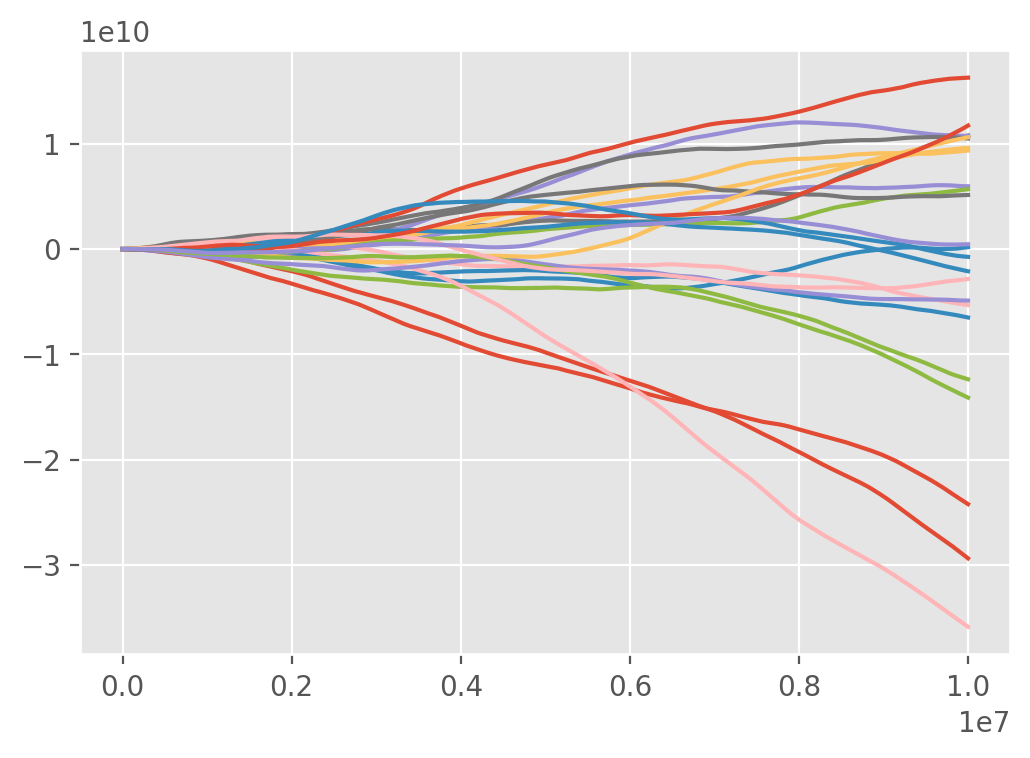

In [44]:
_ = plt.plot(x_trajs.T)

In [45]:
number_of_points = 1000 #may not repeat
data = x_trajs

window_lengths = np.unique(np.exp(np.arange(0,np.log(len(data.T)),np.log(len(data))/number_of_points)).astype(int))

s, L = no_stripe_entropy(data, window_lengths)

100%|██████████| 3575/3575 [00:01<00:00, 2837.94it/s]


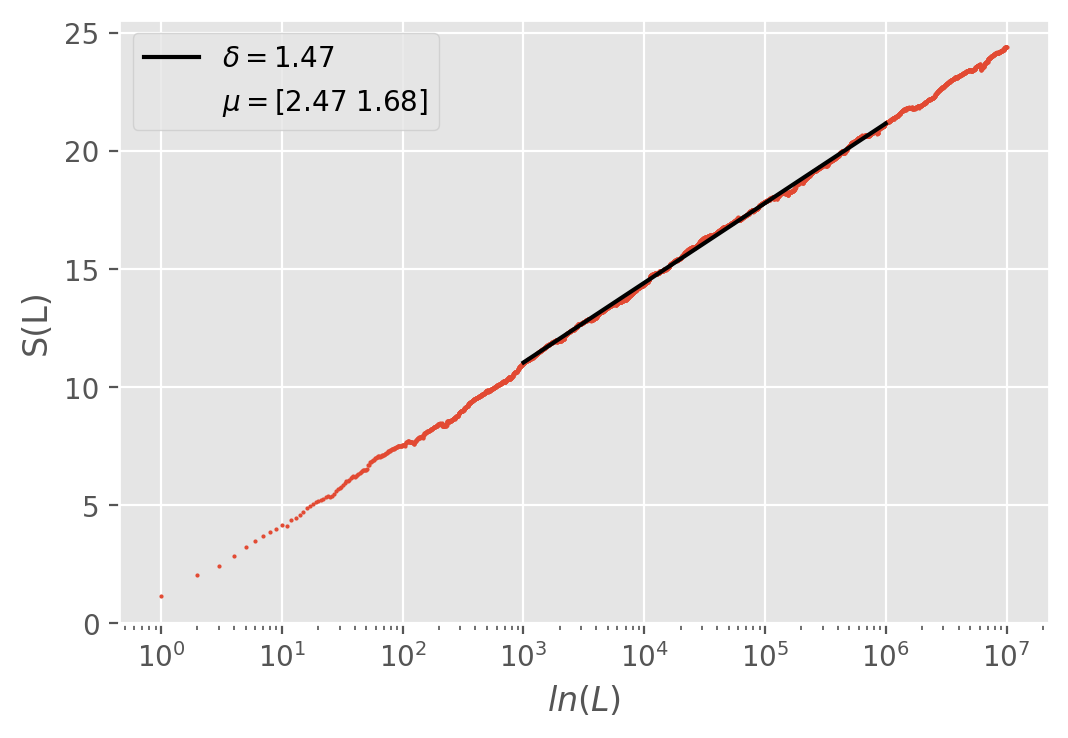

In [46]:
#for fitting and to get the scaling
start = 1*10**3
stop = 1*10**6
fit = get_scaling(s, L, start, stop)
mu = get_mu(fit[1][0])

plt.scatter(L, s, 1)
plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
        label='$\delta = $'+str(np.round(fit[1][0], 2)))
plt.plot([], [], linestyle='', label='$\mu = $'+str(np.round(mu, 2)))
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('S(L)')
plt.legend(loc=0)

In [90]:
from sklearn.linear_model import LinearRegression

In [99]:
lm = LinearRegression()

lm.fit(np.array([1,2,3]).reshape(-1,1), np.array([1,2,3]).reshape(-1,1))

LinearRegression()

In [98]:
np.array([1,2,3,4,5]).reshape(-1,1)

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [64]:
test = np.array([np.array([1,2,3,2]),np.array([4,5,1]),np.array([10 , 1])], dtype = object)

In [55]:
np.shape(test)

(3, 4)

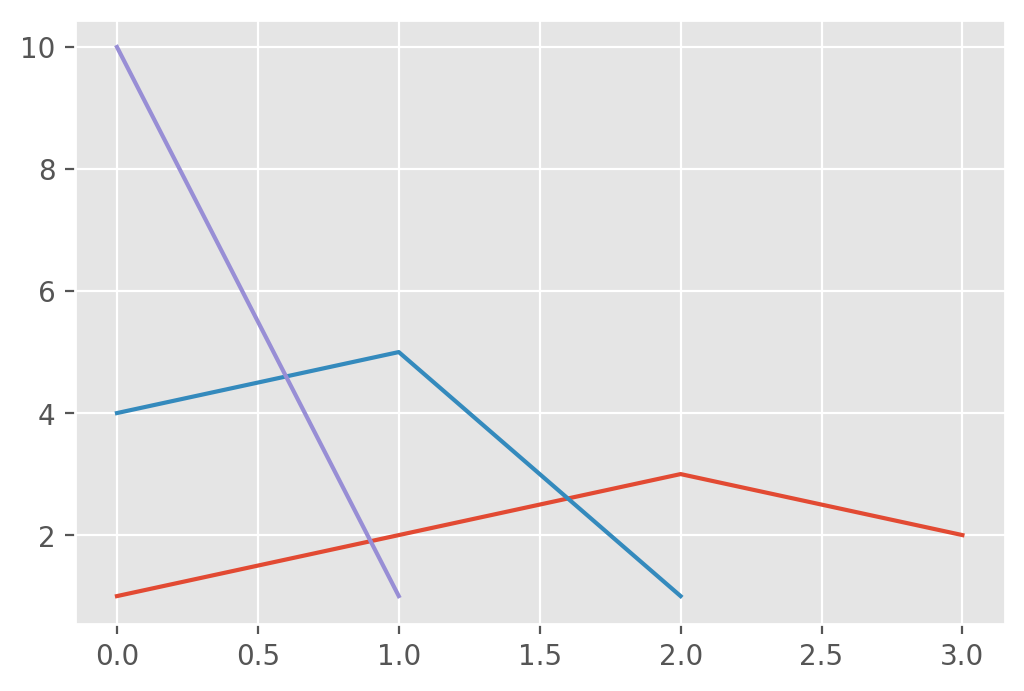

In [57]:
_ = plt.plot(test.T)

In [65]:
for t in test:
    print(t)

[1 2 3 2]
[4 5 1]
[10  1]


In [74]:
type(test)

numpy.ndarray

In [72]:
test2 = np.array([1,2,3])

type(test2)

numpy.ndarray

In [ ]:
trajectory = np.array(np.array([0,6,7,8,9]),np.array([1,2,3,4,11,4]),np.array([4,5,6]), dtype = object)
window_lengths = np.array([2,3,4])

#def new_no_stripe_entropy(trajectory, window_lengths):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. FOR NO STRIPES JUST PASS THE DATA SERIES.

    Returns
    ----------
    S : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L.

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
trajectory = np.array(trajectory)
window_lengths = np.array(window_lengths)
            
if isinstance(trajectory[0], (np.ndarray, list)):
    
        
#window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)
S = []
for L in tqdm(window_lengths):
    if growing_window:
        window_starts = 0
        window_ends = L
    else:
        window_starts = np.arange(0, np.shape(trajectory[0])-L, 1)
        window_ends = np.arange(L, np.shape(trajectory[0]), 1)
    traj = trajectory[:,window_starts].T - trajectory[:,window_ends].T
    counts, bin_edge = np.histogram(traj, bins='doane')  # doane least bad for nongaussian
    counts = np.array(counts[counts != 0])
    binsize = bin_edge[1] - bin_edge[0]
    P = counts / sum(counts)
    S.append(-sum(P*np.log(P)) + np.log(binsize))
    #return S, window_lengths

In [29]:
trajectory = np.array([np.array([0,6,7,8,9]),np.array([1,2,3,4,11,4]),np.array([4,5,6])], dtype = object)

In [73]:
trajectory[0:2]

array([array([0, 6, 7, 8, 9]), array([ 1,  2,  3,  4, 11,  4])],
      dtype=object)

In [16]:
type(trajectory)

numpy.ndarray

In [21]:
test2 = 1

In [57]:
test2[0]

TypeError: 'int' object is not subscriptable

In [24]:
np.nan-1

nan

In [234]:
test = np.array([1,2,-5,1,2,3,4,5,-10,1,2,3,-2])
print(test)

[  1   2  -5   1   2   3   4   5 -10   1   2   3  -2]


In [324]:
def matrix_neg_nan(list_array):
    
    """
    Takes an array and seperates the list at negative values. Then rejoined into a matrix with nan values.
    
    Parameters
    ----------
    
    list_array :
        Array that will be seperated at negative values.
    
    Returns
    -------
    
    sep_traj:
        Numpy array with nan values. (matrix)
    """
    

    neg_indicies = np.where(list_array<0)[0] #find indicies where negative values

    traj_length = np.diff(neg_indicies, prepend=-1) #

    sep_traj = np.array_split(test,neg_indicies+1)[:-1]

    def append_stuff(a, b):
        return np.append(a,np.full(b,np.NaN))

    sep_traj = np.array(list(map(append_stuff, sep_traj, max(traj_length)-traj_length)))

    return sep_traj

In [325]:
matrix_nan(test)

array([[  1.,   2.,  -5.,  nan,  nan,  nan],
       [  1.,   2.,   3.,   4.,   5., -10.],
       [  1.,   2.,   3.,  -2.,  nan,  nan]])

In [233]:
np.array_split(test,np.where(test<0)[0]+1)[:-1]

[array([ 1,  2, -5]),
 array([  1,   2,   3,   4,   5, -10]),
 array([ 1,  2,  3, -2])]

In [148]:
np.diff(np.array([10,2,5,6,5,9,7]))

array([-8,  3,  1, -1,  4, -2])

In [204]:
np.NaN

nan

In [239]:
np.full(5,np.NaN)

array([nan, nan, nan, nan, nan])

In [263]:
np.append([[1,2],[4,5]],[[9,9,9],[9,9,9]],axis=1)

array([[1, 2, 9, 9, 9],
       [4, 5, 9, 9, 9]])

In [288]:
np.full(5,9)

array([9, 9, 9, 9, 9])

In [302]:
def append_stuff(a, b):
    return np.append(a,np.full(b,np.NaN))

In [303]:
list(map(append_stuff,[[1,2,4],[3,5],[9]],[2,3,0]))

[array([ 1.,  2.,  4., nan, nan]),
 array([ 3.,  5., nan, nan, nan]),
 array([9.])]

In [493]:
def apply_stripes(data, stripes): 
    """
    Rounds `data` to `stripes` evenly spaced intervals.
    Every stripe is now at an integer.

    Parameters
    ----------
    data : array_like
        Time-series data to be examined.
    stripes : int
        Number of stripes to apply.

    Returns
    ----------
    rounded_data : ndarray
        `data` rounded to `stripes` number of equally spaced intervals.
    """
    
    data = np.array(data)
    
    #Now see if you have a list or a matrix.
    if len(np.shape(data)) < 2: #The shape of a matrix has 2 numbers.
        data = np.array([data]) #Make the list a psudo matrix with "[list]"
    
    #Subtract the minimum.
    #This will place the minimum at zero.
    data = (data.T - np.min(data,1)).T
    
    #Now resize the data
    data_width = np.max(data,1) - np.min(data,1)
    stripe_size = data_width / stripes
    rounded_data = data.T / stripe_size
    
    return rounded_data.T

In [494]:
def find_events(series):
    """
    Records an event (1) when `series` croses a stripe.
    
    Parameters
    ----------
    series : array-like
        Series with rounded data. Integers are the 'stripes'
        
    Returns
    -------
    event_array: array-like
        Array of when events occur. Events are crossings: 1 -> crossing, 0 -> not a crossing.
    
    """
    
    #Make sure series is a numpy array.
    series = np.array(series)
    
    #Now see if you have a list or a matrix.
    if len(np.shape(series)) < 2: #The shape of a matrix has 2 numbers.
        series = np.array([series]) #Make the list a psudo matrix with "[list]"
    
    #This is the top of the stripe.
    top_stripe = np.floor(series[:,:-1])+1

    #This is the bottom of the stripe.
    bottom_stripe = np.ceil(series[:,:-1])-1

    #Check to see if a crossing has occured.
    event_array = np.logical_not(np.logical_and(series[:,1:] < top_stripe, series[:, 1:] > bottom_stripe))
    
    #Append 0's
    event_array = np.append(event_array, np.zeros([len(event_array),1]), 1)
    
    return event_array*1 #Convert to integers

In [495]:
def make_trajectory(events):
    """
    Constructs diffusion trajectory from events.
    
    Parameters
    ----------
    events : array-like
        Array of when events occur.
        
    Returns
    -------
    trajectory : array-like
        Created step ahead diffusion trajectory.

    """
    
    events = np.array(events)
    
    #Now see if you have a list or a matrix.
    if len(np.shape(events)) < 2: #The shape of a matrix has 2 numbers.
        series = np.array([events]) #Make the list a psudo matrix with "[list]"
    
    #Step ahead diffusion trajectory.
    trajectory = np.cumsum(events, 1)
    
    return trajectory

In [496]:
def entropy(trajectory, window_lengths, window_type):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. Constructed by make_trajectory.

    Returns
    ----------
    s : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L. 

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    #make sure trajectory is a numpy array
    trajectory = np.array(trajectory)
    
    #Now see if you have a list or a matrix.
    if len(np.shape(trajectory)) < 2: #The shape of a matrix has 2 numbers.
        trajectory = np.array([trajectory]) #Make the list a psudo matrix with "[list]"
    
    S = []
    #window_lengths = np.arange(1, int(0.25*len(trajectory)), 1) #1000 poinrs
    for L in tqdm(window_lengths):
        #Moving window (1 trajectory)
        if window_type == 'moving':
            window_starts = np.arange(0, len(trajectory)-L, 1)
            window_ends = np.arange(L, len(trajectory), 1)
        #Growing window (multiple trajectories)
        elif window_type == 'growing':
            window_starts = 0
            window_ends = L
        #Displacements for trajectory
        displacements = trajectory[:,window_ends].T - trajectory[:,window_starts].T
        
        #Now use a histogram
        bin_counts = np.bincount(displacements.flatten().astype(int))
        bin_counts = bin_counts[bin_counts != 0]
        
        #Shannon Entropy
        P = bin_counts / np.sum(bin_counts)
        S.append(-np.sum(P * np.log(P)))
    return S, window_lengths

In [444]:
test = np.array([[1,3,12,22,5],[1,2,1,2,2]])

data = test
stripes = 10
show_plot = True

rounded_data = apply_stripes(data, stripes)
event_array = find_events(rounded_data)
diffusion_trajectory = make_trajectory(event_array)
window_lengths = np.array([1,2,3])
s, L = entropy(diffusion_trajectory, window_lengths, 'growing')

100%|██████████| 3/3 [00:00<00:00, 5552.92it/s]


In [446]:
L

array([1, 2, 3])

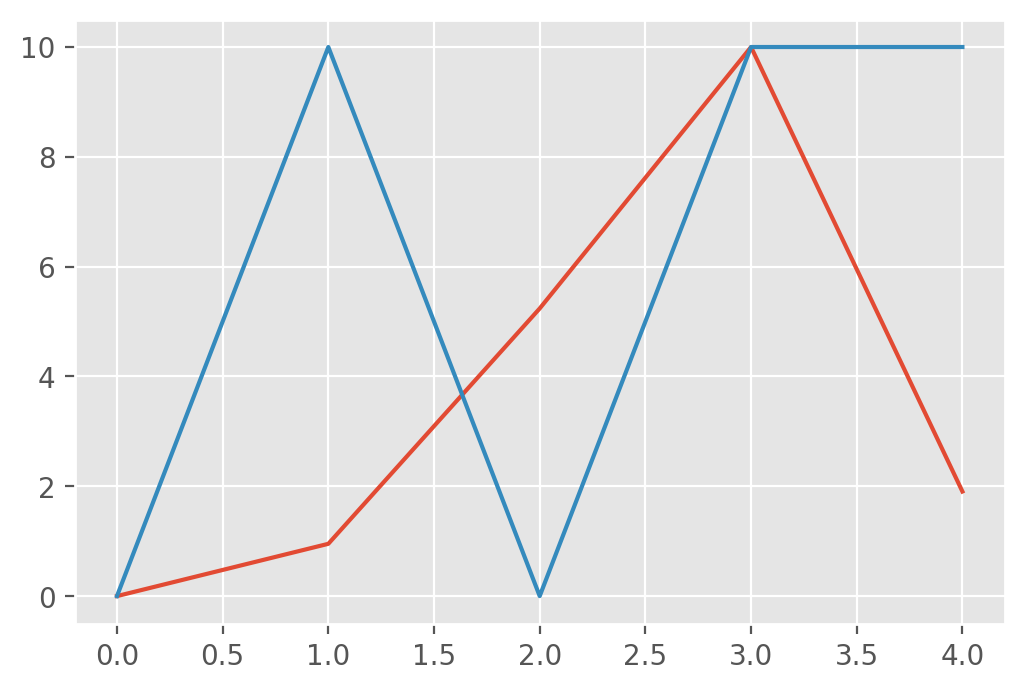

In [93]:
_ = plt.plot(rounded_data.T)

In [399]:
test = np.array([[1,1,1,1,6],[0,1,0,1,3]])

#bin_counts = np.apply_along_axis(np.bincount, 1, test, minlength=np.max(test)+1)

bin_counts = np.bincount(np.flat([[1,3,3],[1,3,4]]))
print(bin_counts)

#bin_counts[bin_counts != 0]

AttributeError: module 'numpy' has no attribute 'flat'

In [417]:
np.bincount(np.array([[1,2],[3,3]]).flatten())

array([0, 1, 1, 2])

In [413]:
np.bincount(np.array([[1.1,2],[3,3]]))

ValueError: object too deep for desired array

In [147]:
np.equal([0,1,2],[1,5,5])

array([False, False, False])

In [336]:
len([1,2])

2

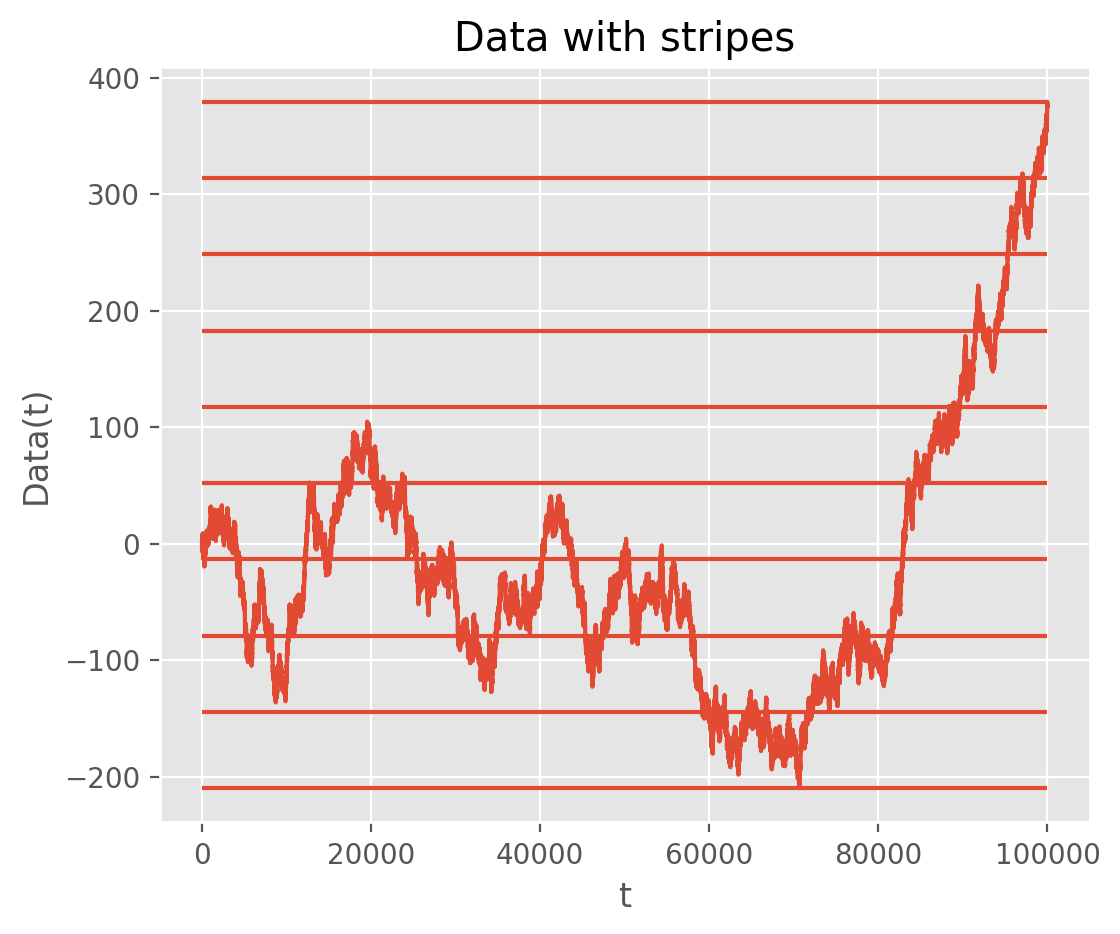

100%|██████████| 24998/24998 [00:19<00:00, 1308.47it/s]


In [489]:
data = x
stripes = 10
show_plot = True

rounded_data = apply_stripes(data, stripes, True)
event_array = find_events(rounded_data)
diffusion_trajectory = make_trajectory(event_array)
window_lengths = np.arange(1, int(0.25*len(diffusion_trajectory)), 1) #1000 poinrs
s, L = entropy(diffusion_trajectory, window_lengths)

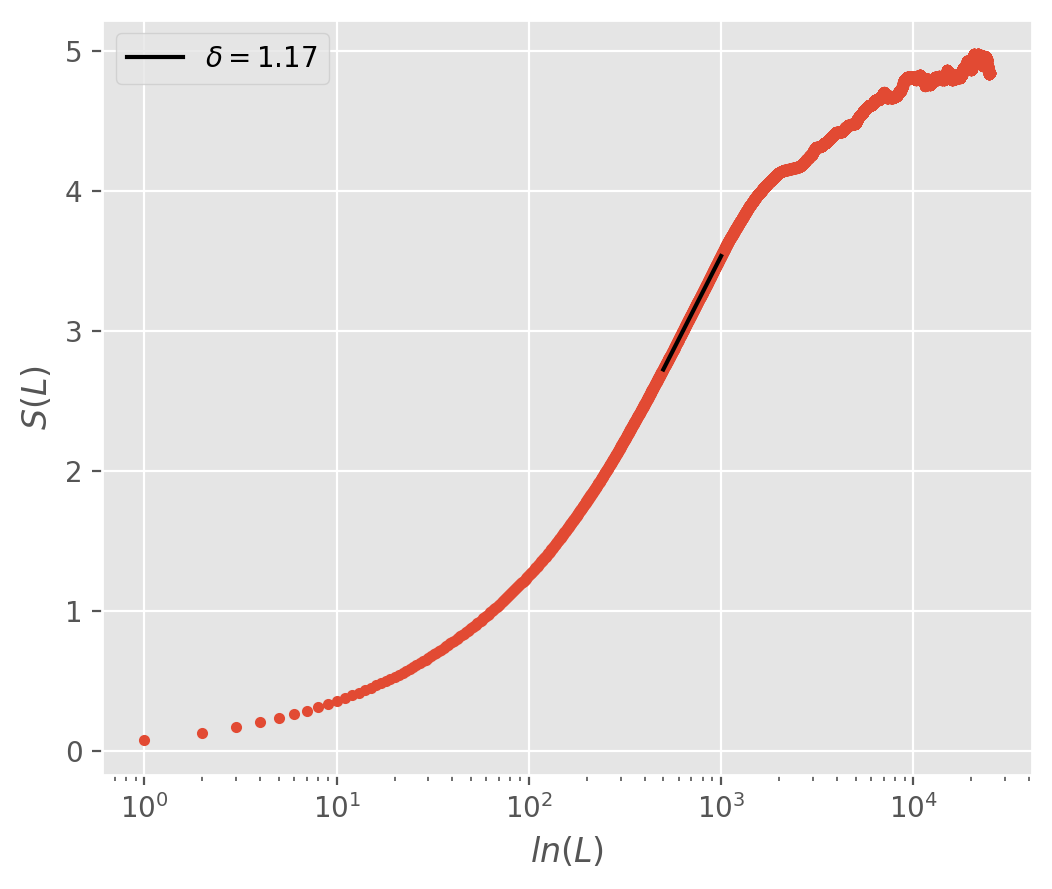

In [492]:
start = 5*10**2
stop = 1*10**3

fit = get_scaling(s, L, start, stop)

plt.figure(figsize = (6, 5))
plt.plot(L, s, linestyle='', marker='.')
plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
             label='$\delta = $'+str(np.round(fit[1][0], 2)))
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('$S(L)$')
plt.legend(loc=0)

In [511]:
data = x
stripes = 10
show_plot = True

rounded_data = apply_stripes(data, stripes)
event_array = find_events(rounded_data)
diffusion_trajectory = make_trajectory(event_array)
window_lengths = np.arange(1, int(0.25*len(diffusion_trajectory)), 1) #1000 poinrs
s, L = entropy(diffusion_trajectory, window_lengths, 'growing')

0it [00:00, ?it/s]


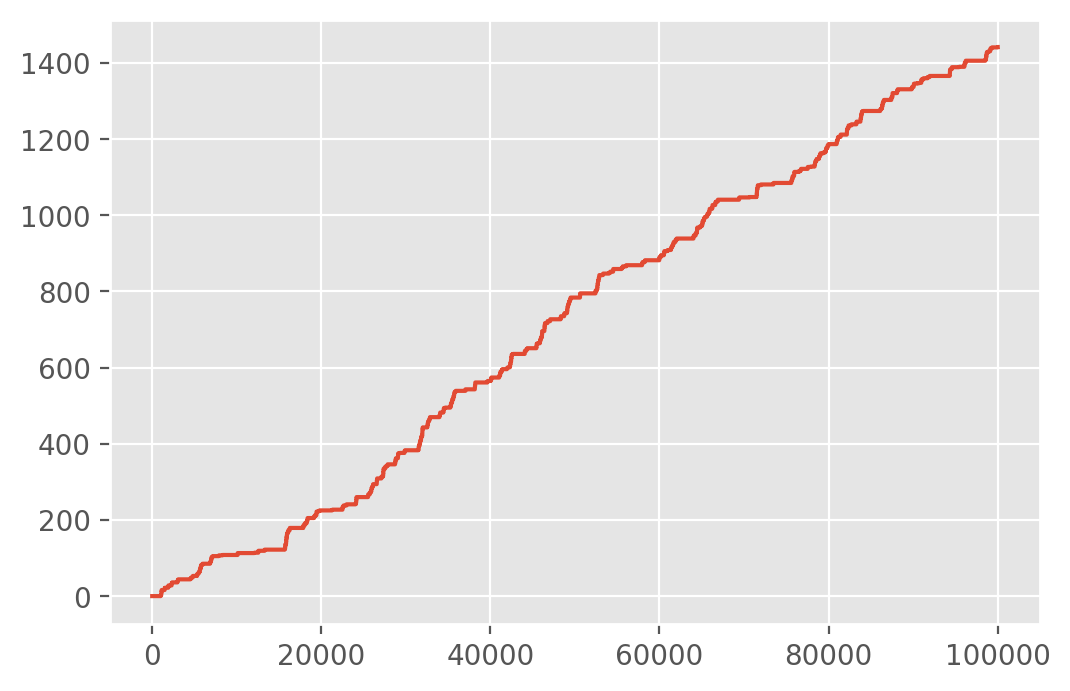

In [510]:
_ = plt.plot(diffusion_trajectory.T)

In [513]:
L

array([], dtype=int64)

In [ ]:
start = 1*10**2
stop = 1*10**3

fit = get_scaling(s, L, start, stop)

plt.figure(figsize = (6, 5))
plt.plot(L, s, linestyle='', marker='.')
plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
             label='$\delta = $'+str(np.round(fit[1][0], 2)))
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('$S(L)$')
plt.legend(loc=0)